In [16]:
!pip -q install folium
!pip -q install contextily
!pip -q install geopandas
!pip -q install shapely
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

df = pd.read_csv('Real estate.csv')

display(df.head())

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


## **Описательный анализ данных (EDA)**

### **Описание датасета**

Датасет содержит данные о сделках по жилой недвижимости, собранные в районе Синьдянь, г. Новый Тайбэй, Тайвань. Набор данных включает 414 наблюдений и 7 числовых признаков. Каждое наблюдение соответствует одной сделке.

### **Описание признаков датасета**

- **X1 transaction date** — дата сделки, год с дробной частью  
- **X2 house age** — возраст дома, годы  
- **X3 distance to the nearest MRT station** — расстояние до ближайшей станции метро, метры  
- **X4 number of convenience stores** — количество магазинов шаговой доступности  
- **X5 latitude** — географическая широта, градусы  
- **X6 longitude** — географическая долгота, градусы  
- **Y house price of unit area** — цена недвижимости за единицу площади, новые тайваньские доллары (NTD)


### **Диаграммы признаков датасета**

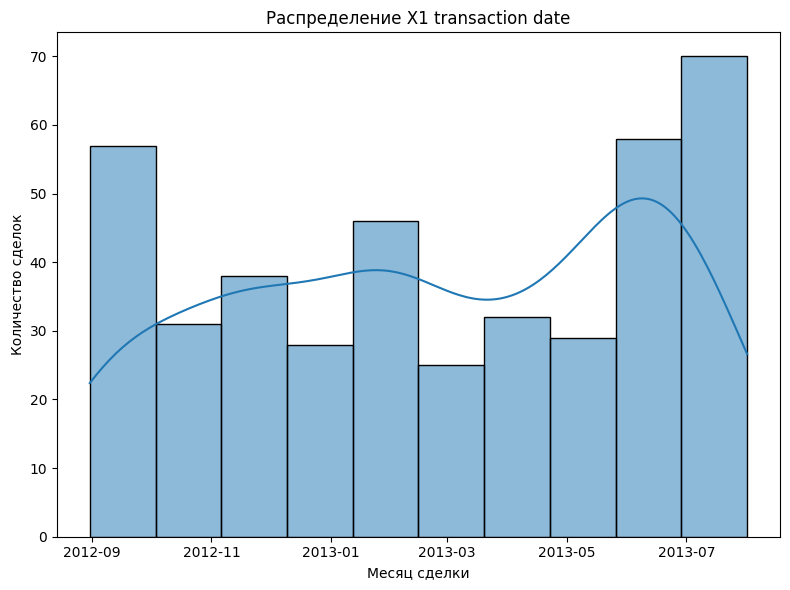

In [4]:
# Приведем дату к понятному виду
df['X1 transaction date'] = (
    pd.to_datetime(df['X1 transaction date'].astype(int).astype(str) + '-01-01')
    + pd.to_timedelta(
        df['X1 transaction date'] % 1 * 365.25,
        unit='D'
    )
).dt.normalize()

plt.figure(figsize=(8, 6))
sns.histplot(df['X1 transaction date'], kde=True)
plt.title('Распределение X1 transaction date')
plt.xlabel('Месяц сделки')
plt.ylabel('Количество сделок')
plt.tight_layout()
plt.show()

**House age.** Возраст домов лежит в диапазоне от 0 до 45 лет. Основная масса объектов сосредоточена в интервалах 10–20 и 30–40 лет. Они включают около 170 и 90 сделок соответственно. Наименьшее количество фиксируется в интервале 20-30 лет – всего около 40 сделок.

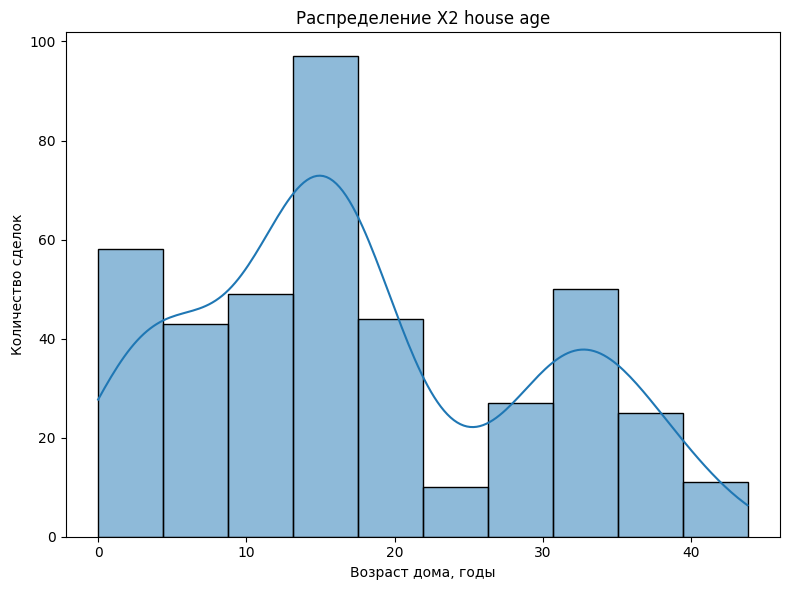

In [5]:
plt.figure(figsize=(8, 6))
sns.histplot(df['X2 house age'], kde=True)
plt.title('Распределение X2 house age')
plt.xlabel('Возраст дома, годы')
plt.ylabel('Количество сделок')
plt.tight_layout()
plt.show()

**Distance to the nearest MRT station.** Расстояние до ближайшей станции метро находится в диапазоне от нескольких десятков метров до  нескольких километров. Например, наименьшее расстояние объекта до станции составляет 23 метра, а наибольшее – 6488 метров. Основная масса домов располагается на расстоянии менее километра. Также заметен небольшой локальный подъем частоты в области около 4000–4500 метров, что указывает на отдельные группы объектов, расположенных за пределом основной части города.

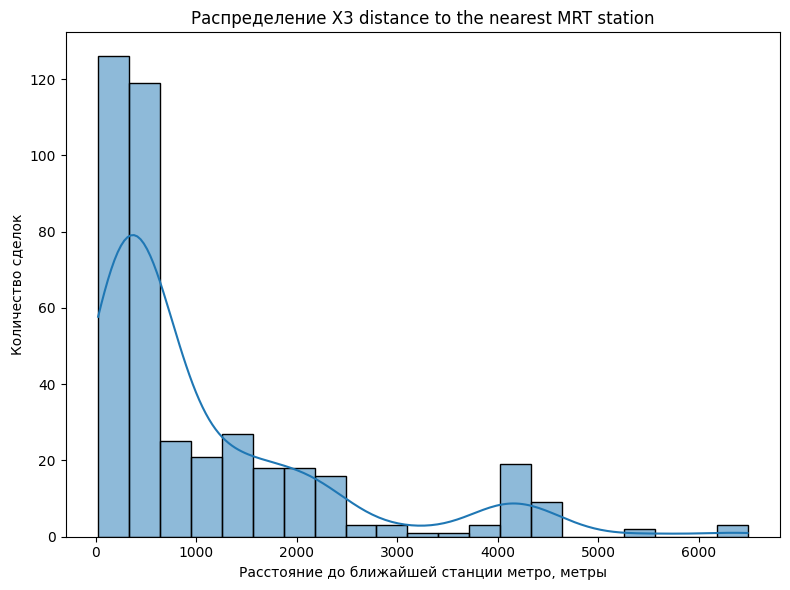

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(df['X3 distance to the nearest MRT station'], kde=True)
plt.title('Распределение X3 distance to the nearest MRT station')
plt.xlabel('Расстояние до ближайшей станции метро, метры')
plt.ylabel('Количество сделок')
plt.tight_layout()
plt.show()

**Number of convenience stores.** Количество магазинов варьируется от 0 до 10. Большинство объектов имеет поблизости от 0 до 5 магазинов. Наибольшее число сделок имеют дома без магазинов поблизости , а также дома с медианным числом магазинов – пятью (по 67 сделок).  Домов, имеющих максимальное число магазинов рядом, на порядок меньше – всего 10.

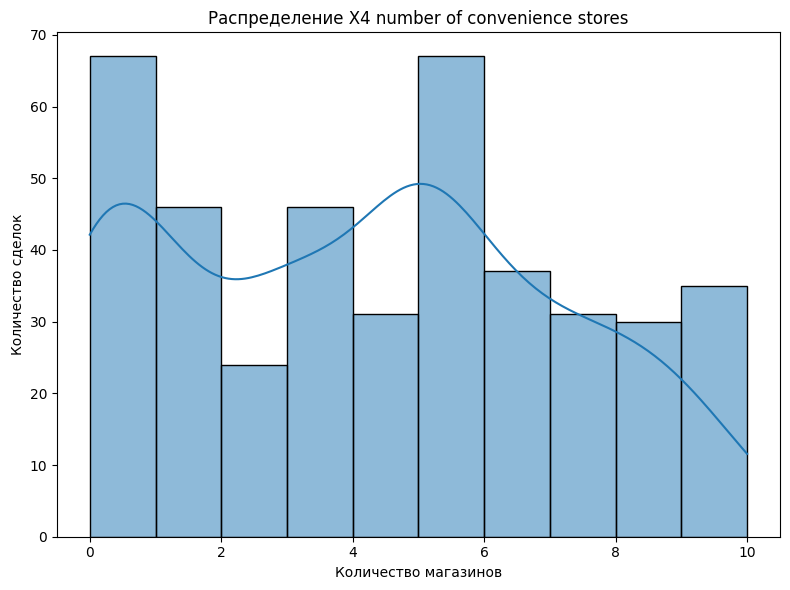

In [7]:
plt.figure(figsize=(8, 6))
sns.histplot(df['X4 number of convenience stores'], kde=True)
plt.title('Распределение X4 number of convenience stores')
plt.xlabel('Количество магазинов')
plt.ylabel('Количество сделок')
plt.tight_layout()
plt.show()

**Latitude and longitude.** Координаты распределены достаточно плотно – все объекты помещаются в прямоугольник [121.47, 121.57]×[24.93, 25.02]. Он охватывает самую густонаселенную площадь района. На карте видно, что значительная часть объектов расположена на наиболее урбанизированной территории – на востоке от русла реки Синьдянь. Южнее основной части города, а также на западе от русла реки расположены небольшие группы по 2-10 объектов. Для дальнейшего анализа имеет смысл разделить объекты на два кластера: **центральный** – плотная зона на востоке от реки Синьдянь, и **пригородный** – небольшие группы и единичные объекты южнее основной части города и на западном берегу. Из-за разного уровня урбанизации эти объекты различаются по остальным признакам набора данных: числу магазинов, близости к метро и возрасту.

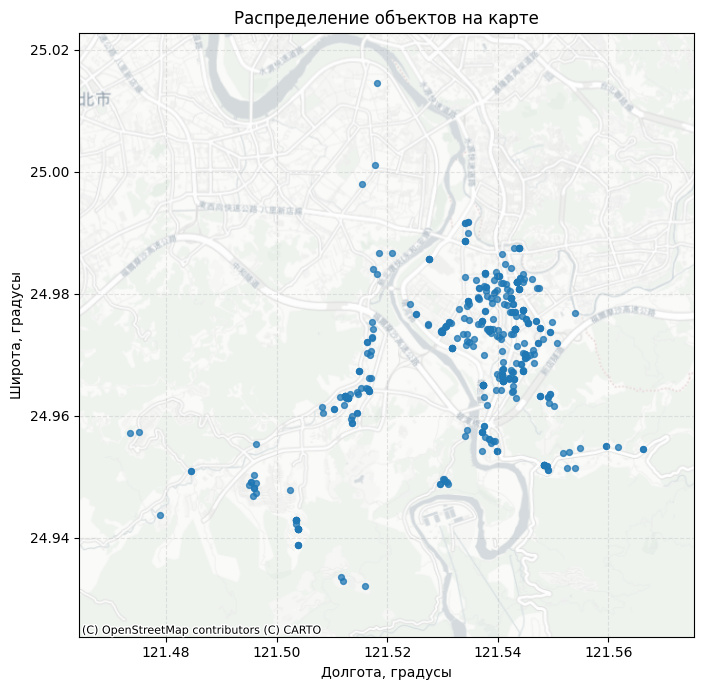

In [8]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["X6 longitude"], df["X5 latitude"]),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(9, 7))

minx, miny, maxx, maxy = gdf.total_bounds
pad_x = (maxx - minx) * 0.10
pad_y = (maxy - miny) * 0.10
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs="EPSG:4326"
)

gdf.plot(ax=ax, markersize=18, alpha=0.75)

ax.set_title("Распределение объектов на карте")
ax.set_xlabel("Долгота, градусы")
ax.set_ylabel("Широта, градусы")

ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


### **Графики относительно цены объекта**

**Convenience stores.**  На диаграмме рассеяния видно, что с увеличением числа магазинов рядом с объектом в среднем возрастает стоимость жилья за единицу площади: группы точек смещаются вверх при переходе от 0–4 магазинов к 5–10. При этом внутри каждой категории наблюдается значительный разброс цен.

Также присутствуют отдельные выбросы — как очень дорогие сделки при малом числе магазинов, так и редкие низкие значения при среднем числе. График ящиков с усами показывает, что при увеличении числа магазинов от 0 до 6 медианная стоимость жилья последовательно растет. При дальнейшем увеличении числа магазинов заметного роста медианной цены не наблюдается, за исключением значения 9, для которого медианная стоимость максимальна.


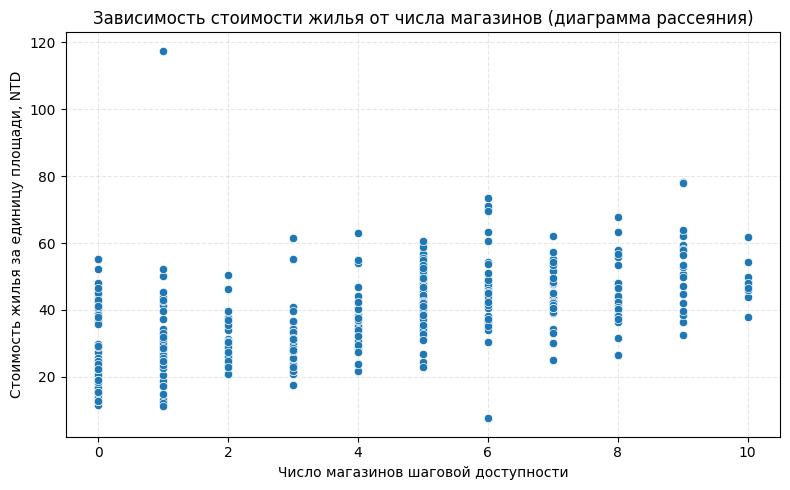

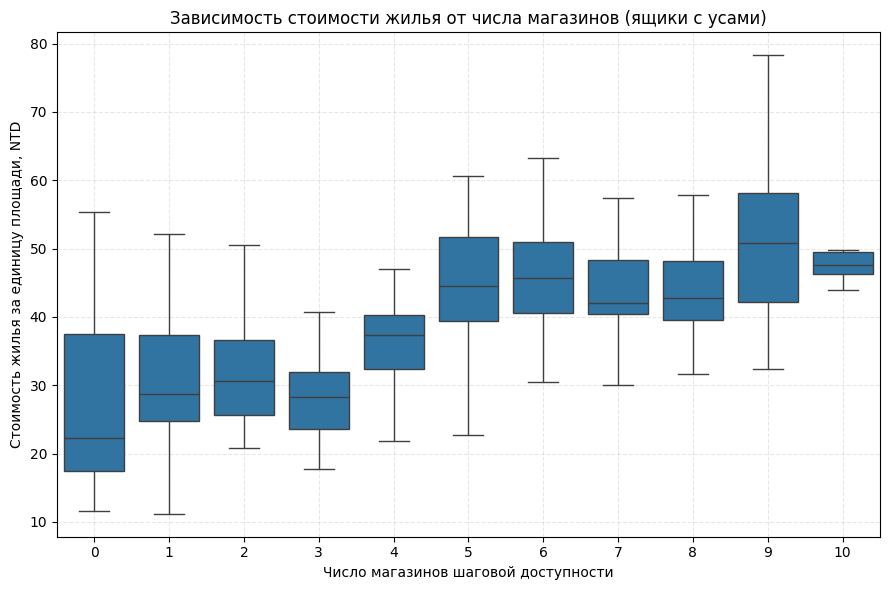

In [10]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="X4 number of convenience stores",
    y="Y house price of unit area"
)

plt.title("Зависимость стоимости жилья от числа магазинов (диаграмма рассеяния)")
plt.xlabel("Число магазинов шаговой доступности")
plt.ylabel("Стоимость жилья за единицу площади, NTD")

plt.gca().set_axisbelow(True)
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 6))

sns.boxplot(
    data=df,
    x="X4 number of convenience stores",
    y="Y house price of unit area",
    order=range(0, 11),
    showfliers=False
)

plt.title("Зависимость стоимости жилья от числа магазинов (ящики с усами)")
plt.xlabel("Число магазинов шаговой доступности")
plt.ylabel("Стоимость жилья за единицу площади, NTD")

plt.gca().set_axisbelow(True)
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


**Distance to MRT.** На первои графике заметна отрицательная зависимость: чем дальше от станции, тем чаще цена ниже. Однако основная часть наблюдений сосредоточена на расстояниях примерно до 1000 метров, из-за чего точки слева расположены слишком плотно. Это затрудняет оценку связи признаков, поэтому рассмотрим график с логарифмической шкалой по оси расстояния до метро. На ней видно, что при переходе от сотен метров к нескольким километрам уровень цен плавно снижается, что подтверждает предположение о значительном влиянии расстояния до метро на стоимость жилья.


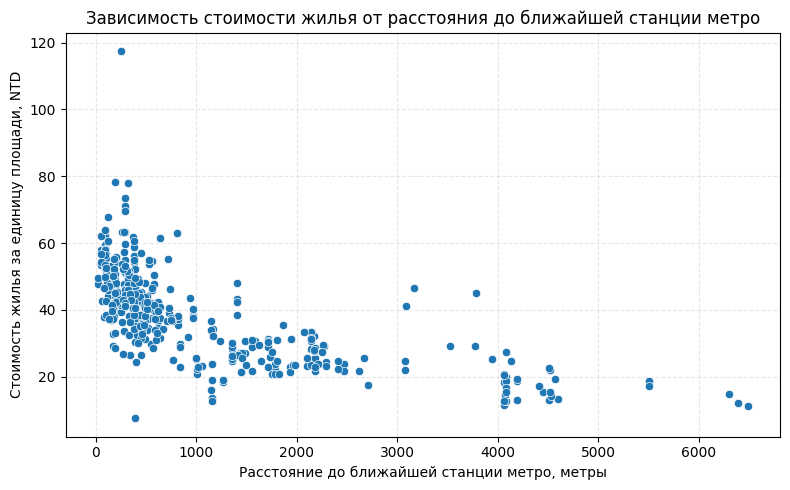

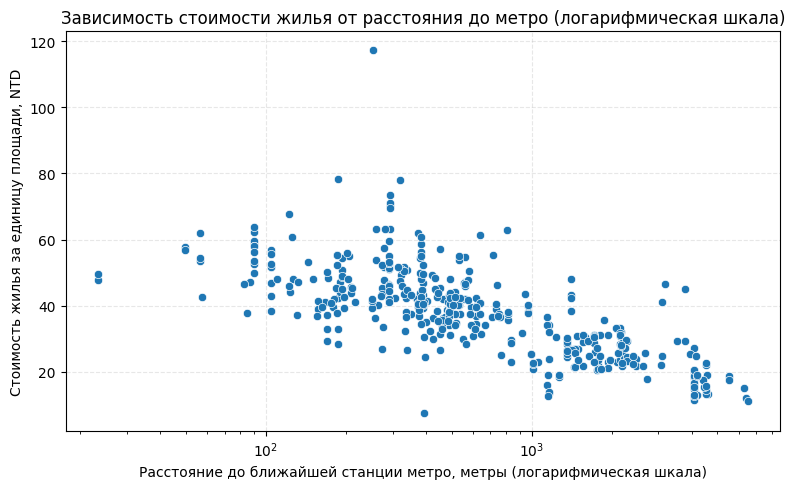

In [11]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="X3 distance to the nearest MRT station",
    y="Y house price of unit area"
)

plt.title("Зависимость стоимости жилья от расстояния до ближайшей станции метро")
plt.xlabel("Расстояние до ближайшей станции метро, метры")
plt.ylabel("Стоимость жилья за единицу площади, NTD")

plt.gca().set_axisbelow(True)
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=df,
    x="X3 distance to the nearest MRT station",
    y="Y house price of unit area"
)

plt.xscale("log")

plt.title("Зависимость стоимости жилья от расстояния до метро (логарифмическая шкала)")
plt.xlabel("Расстояние до ближайшей станции метро, метры (логарифмическая шкала)")
plt.ylabel("Стоимость жилья за единицу площади, NTD")

plt.gca().set_axisbelow(True)
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()



**House age.** Распределение зависимости цены объекта от его возраста выглядит следующим образом: для домов возрастом от 0 до 25 лет характерна отрицательная зависимость – чем старше дом, тем он дешевле. Однако для объектов старше 25 лет их стоимость, напротив, начинает возрастать.
Как отмечалось ранее объекты можно разделить на два кластера: *центральный*, и *пригородный*. В первый входят объекты с расстоянием не более 1000 метров до ближайшего метро, во второй – остальные. Обозначим их на графике разным цветом и увидим, что объекты центрального кластера в целом имеют более высокий уровень цен практически на всем диапазоне возрастов. При этом в пригородном кластере отсутствуют объекты старше 35 лет. Таким образом, в обоих кластерах с увеличением возраста дома стоимость жилья в среднем снижается.


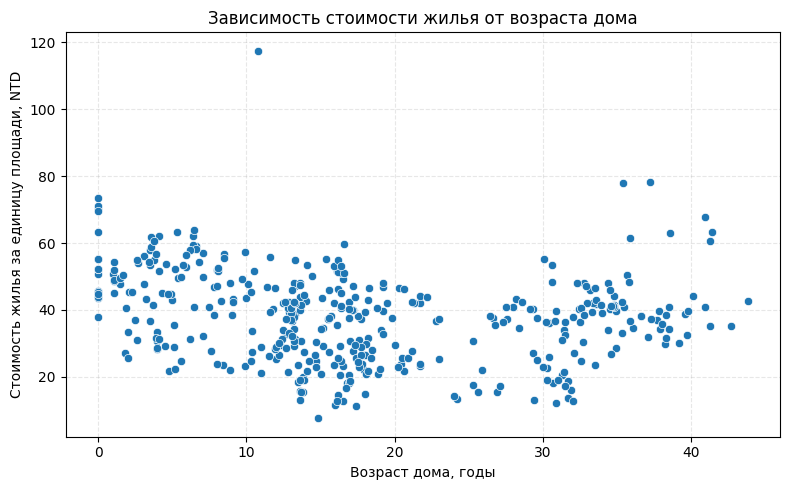

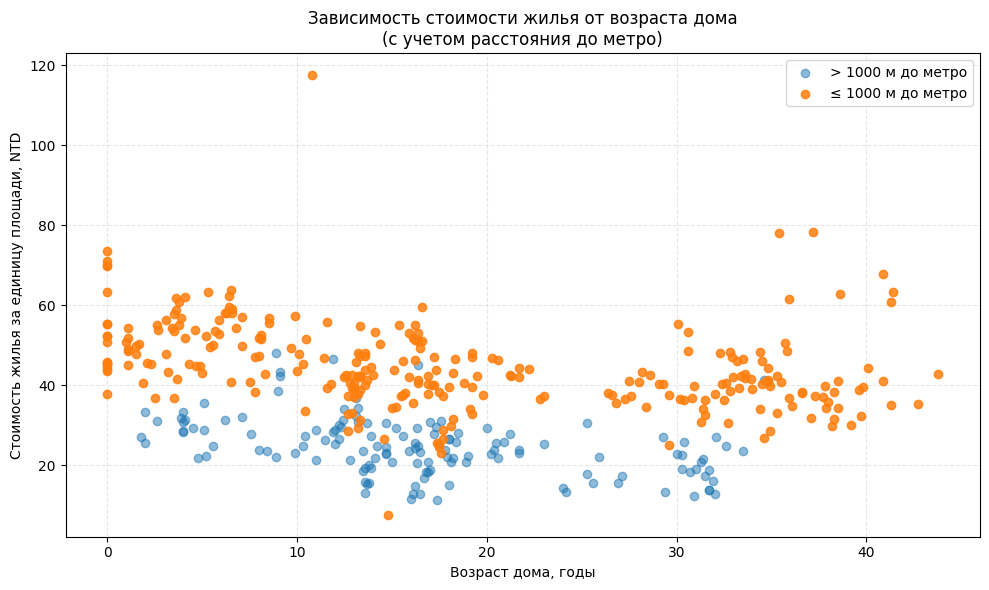

In [13]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="X2 house age",
    y="Y house price of unit area"
)

plt.title("Зависимость стоимости жилья от возраста дома")
plt.xlabel("Возраст дома, годы")
plt.ylabel("Стоимость жилья за единицу площади, NTD")

plt.gca().set_axisbelow(True)
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

thr = 1000

mask_near = df["X3 distance to the nearest MRT station"] <= thr
mask_far = ~mask_near

x_near = df.loc[mask_near, "X2 house age"]
y_near = df.loc[mask_near, "Y house price of unit area"]

x_far = df.loc[mask_far, "X2 house age"]
y_far = df.loc[mask_far, "Y house price of unit area"]

plt.figure(figsize=(10, 6))

plt.scatter(x_far, y_far, alpha=0.5, label=f"> {thr} м до метро")
plt.scatter(x_near, y_near, alpha=0.85, label=f"≤ {thr} м до метро")

plt.title("Зависимость стоимости жилья от возраста дома\n(с учетом расстояния до метро)")
plt.xlabel("Возраст дома, годы")
plt.ylabel("Стоимость жилья за единицу площади, NTD")

plt.gca().set_axisbelow(True)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

**Связь стоимости с расположением.** На карте показано распределение стоимости жилья за единицу площади: цвет каждой точки демонстрирует стоимость объекта – чем темнее оттенок, тем выше стоимость. Видно, что наиболее дорогие объекты концентрируются в *центральной* части области наблюдений. В *пригородных* группах преобладают более светлые оттенки, что соответствует более низкому уровню цен. Таким образом, подтверждается различие между выделенными группами: центральная зона в среднем дороже пригородной.

Для более корректной интерпретации цветовой шкалы были исключены крайние значения цены: нижняя и верхняя границы шкалы заданы как 5-й и 95-й перцентили. Это уменьшает влияние аномально низких и высоких сделок на раскраску карты и делает ее более читаемой.

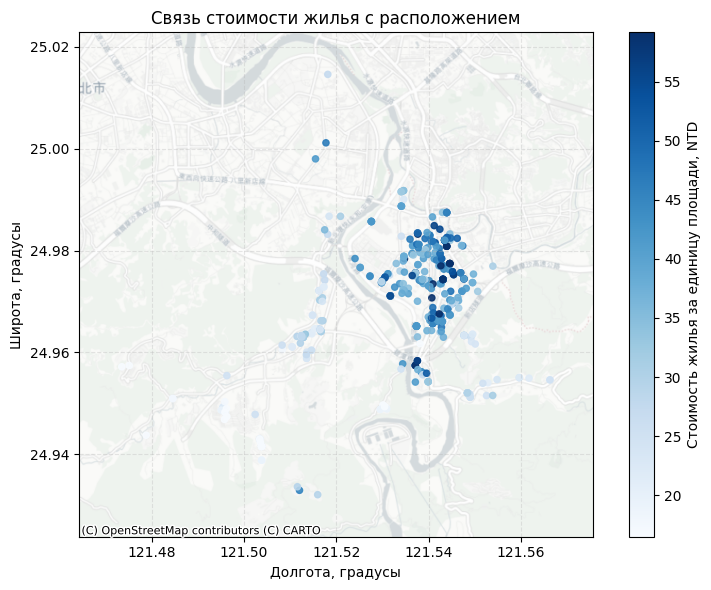

In [17]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["X6 longitude"], df["X5 latitude"]),
    crs="EPSG:4326"
)

vmin = df["Y house price of unit area"].quantile(0.05)
vmax = df["Y house price of unit area"].quantile(0.95)

fig, ax = plt.subplots(figsize=(8, 6))

minx, miny, maxx, maxy = gdf.total_bounds
pad_x = (maxx - minx) * 0.10
pad_y = (maxy - miny) * 0.10
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

gdf.plot(
    ax=ax,
    column="Y house price of unit area",
    cmap="Blues",
    vmin=vmin,
    vmax=vmax,
    alpha=0.9,
    markersize=20
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs="EPSG:4326"
)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Стоимость жилья за единицу площади, NTD")

ax.set_title("Связь стоимости жилья с расположением")
ax.set_xlabel("Долгота, градусы")
ax.set_ylabel("Широта, градусы")
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()